# __ML Unige 2023: Advertisement Impact Prediction__
## Predicting customer subscriptions from an advertisement campaign
### Liam Phan, Michael Bigler and Manuela Giansante

***

# Goal

A company wants to assess the quality of their online advertisement campaign. Online users are the main interest in this campaign. The users see a web banner during their browsing activity. For each user, they want to be able to predict whether they subscribe to the advertised product through the advertisement banner, based on the information they have about them. To subscribe, the user has to click on the banner and then subscribe to the service.

The target variable name is __subscription__.

# Packages

In [138]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from facets_overview.generic_feature_statistics_generator import GenericFeatureStatisticsGenerator
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

In [189]:
# Color palette
main_col = "#274156"
second_col = "#A2A77F"
target_col = "#499167"

# Data

__File descriptions__

MLUnige2023_subscriptions_train.csv - The training set (features + response).

MLUnige2023_subscriptions_test.csv - The test set (features only).

MLUnige2023_sampleSubmission.csv - A sample submission file in the correct format (with random predictions).

<br>

__Data fields__

***

__Unique identifier__

__Id__: a unique identifier of the observations in each dataset. In the test set, it is used to match your predictions with the true values.

***

__Target variable (only in the training data)__

__subscription__: whether the user subscribed through the banner (1:yes, 0:no)

***

__Demographic variables__

__age__: (numeric)

__job__: type of job (categorical: teacher, industrial_worker, entrepreneur, housekeeper, manager, retired, freelance, salesman, student, technology, unemployed, na)

__marital__: marital status (categorical: married, divorced, single)

__education__: (categorical: high_school, university, grad_school, na)

***

__Variables about the current campaign__

__device__: from which device does the user see the banner? (categorical: smartphone, desktop, na)

__day__: last day of the month when the user saw the banner (numeric)

__month__: last month of the year when the user saw the banner (numeric)

__time_spent__: how long the user looked at the banner last time (in seconds) (numeric)

__banner_views__: number of times the user saw the banner (numeric)

***

__Variables about an old campaign for the same product__

__banner_views_old__: number of times the user saw the banner during an old (and related) online ads campaign (numeric)

__days_elapsed_old__: number of days since the user saw the banner of an old (and related) online ads campaign (numeric, -1 if the user never saw the banner)

__outcome_old__: outcome of the old (and related) online ads campaign (categorical: failure, other, success, na)

***

__Variables with no name__

__X1__: (categorical: 1, 0)

__X2__: (categorical: 1, 0)

__X3__: (categorical: 1, 0)

__X4__: (numeric)

***

<br>

We first start by loading both __Datasets__

In [184]:
# Train
train =  pd.read_csv('DATA/MLUnige2023_subscriptions_train.csv', index_col='Id', na_values='na', header=0)
train = train.astype({'job':'category', 'marital':'category', 'education':'category', 'device':'category', 'outcome_old':'category', 'X1':'category', 'X2':'category', 'X3':'category', 'X4':'float64', 'subscription':'category', 'day':'category', 'month':'category'})
train.day = pd.Categorical(train.day, ordered=True)
train.month = pd.Categorical(train.month, ordered=True)

train_categorical = list(train.select_dtypes(include=['category']).columns)
train_numeric = list(train.select_dtypes(include=['int64', 'float64']).columns)

train_numeric_target = train_numeric.copy()
train_numeric_target.append("subscription")

# Test
test =  pd.read_csv('DATA/MLUnige2023_subscriptions_test.csv', index_col='Id', na_values='na', header=0)
test = test.astype({'job':'category', 'marital':'category', 'education':'category', 'device':'category', 'outcome_old':'category', 'X1':'category', 'X2':'category', 'X3':'category', 'X4':'float64', 'day':'category', 'month':'category'})
test.day = pd.Categorical(test.day, ordered=True)
test.month = pd.Categorical(test.month, ordered=True)

test_categorical = list(test.select_dtypes(include=['category']).columns)
test_numeric = list(test.select_dtypes(include=['int64', 'float64']).columns)



Here is our __Train__ Dataset:

In [131]:
train

,age,job,marital,education,device,day,month,time_spent,banner_views,banner_views_old,days_elapsed_old,outcome_old,X1,X2,X3,X4,subscription
Id,,,,,,,,,,,,,,,,,
0,28,freelance,married,grad_school,smartphone,4,2,26.80,3,4,196,failure,0,0,1,0.072803,1
1,48,industrial_worker,married,university,smartphone,30,4,13.05,1,1,79,success,0,0,0,0.075454,1
2,27,teacher,married,university,smartphone,14,7,8.10,3,0,-1,NaN,0,1,1,0.068110,0
3,44,unemployed,divorced,university,smartphone,13,5,7.10,2,1,369,other,0,0,1,0.091942,0
4,29,manager,single,grad_school,smartphone,26,4,15.90,2,2,143,success,0,0,0,0.085922,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8947,54,industrial_worker,married,university,smartphone,16,7,7.30,1,0,-1,NaN,1,0,0,0.072803,0
8948,43,industrial_worker,married,university,smartphone,4,2,37.75,2,0,-1,NaN,0,0,1,0.081456,1
8949,27,manager,single,grad_school,NaN,5,6,29.00,3,0,-1,NaN,0,0,1,0.079186,1


Here is our __Test__ Dataset:

In [132]:
test

,age,job,marital,education,device,day,month,time_spent,banner_views,banner_views_old,days_elapsed_old,outcome_old,X1,X2,X3,X4
Id,,,,,,,,,,,,,,,,
0,53,retired,married,university,NaN,17,6,5.25,1,0,-1,NaN,0,0,1,0.084570
1,61,manager,married,grad_school,smartphone,20,4,9.00,1,0,-1,NaN,0,0,0,0.075227
2,51,industrial_worker,married,university,NaN,4,7,9.65,1,0,-1,NaN,0,0,0,0.075781
3,34,manager,married,grad_school,NaN,28,5,13.45,2,0,-1,NaN,0,0,1,0.070043
4,30,manager,married,grad_school,smartphone,4,5,16.15,2,0,-1,NaN,0,0,0,0.171618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3832,47,industrial_worker,married,NaN,NaN,5,6,19.20,2,0,-1,NaN,0,0,1,0.104216
3833,30,teacher,single,university,smartphone,3,3,3.65,1,0,-1,NaN,1,0,0,0.077552
3834,55,teacher,married,university,NaN,26,6,5.15,5,0,-1,NaN,0,0,1,0.129156


## Duplicates

We check if there is any perfect __duplicates__ in both our Datasets:

In [133]:
# Train
## check for duplicate rows
duplicates = train.duplicated()

## display the duplicate rows
print("\n",train[duplicates])

# Test
## check for duplicate rows
duplicates = test.duplicated()

## display the duplicate rows
print("\n",test[duplicates])


 Empty DataFrame
Columns: [age, job, marital, education, device, day, month, time_spent, banner_views, banner_views_old, days_elapsed_old, outcome_old, X1, X2, X3, X4, subscription]
Index: []

 Empty DataFrame
Columns: [age, job, marital, education, device, day, month, time_spent, banner_views, banner_views_old, days_elapsed_old, outcome_old, X1, X2, X3, X4]
Index: []


The dataframes __Train__ and __Test__ has no duplicate rows. 

## Missings

We then check how many and where are our __missings__ values in both __Train__ and __Test__.

In [134]:
train.isna().sum()

age                    0
job                   61
marital                0
education            378
device              2050
day                    0
month                  0
time_spent             0
banner_views           0
banner_views_old       0
days_elapsed_old       0
outcome_old         6804
X1                     0
X2                     0
X3                     0
X4                     0
subscription           0
dtype: int64

In [135]:
test.isna().sum()

age                    0
job                   21
marital                0
education            160
device               901
day                    0
month                  0
time_spent             0
banner_views           0
banner_views_old       0
days_elapsed_old       0
outcome_old         2937
X1                     0
X2                     0
X3                     0
X4                     0
dtype: int64

In both Datasets, we have a lot of __missings__ in __outcome_old__, __device__, __education__ and __job__

We also know that __day_elapsed_old__ is having the same __missings__ as __outcome_old__, just encoded as -1 instead. We can also __visualize__ it with a plot:

Text(0.5, 1.0, 'Missing Values on Train')

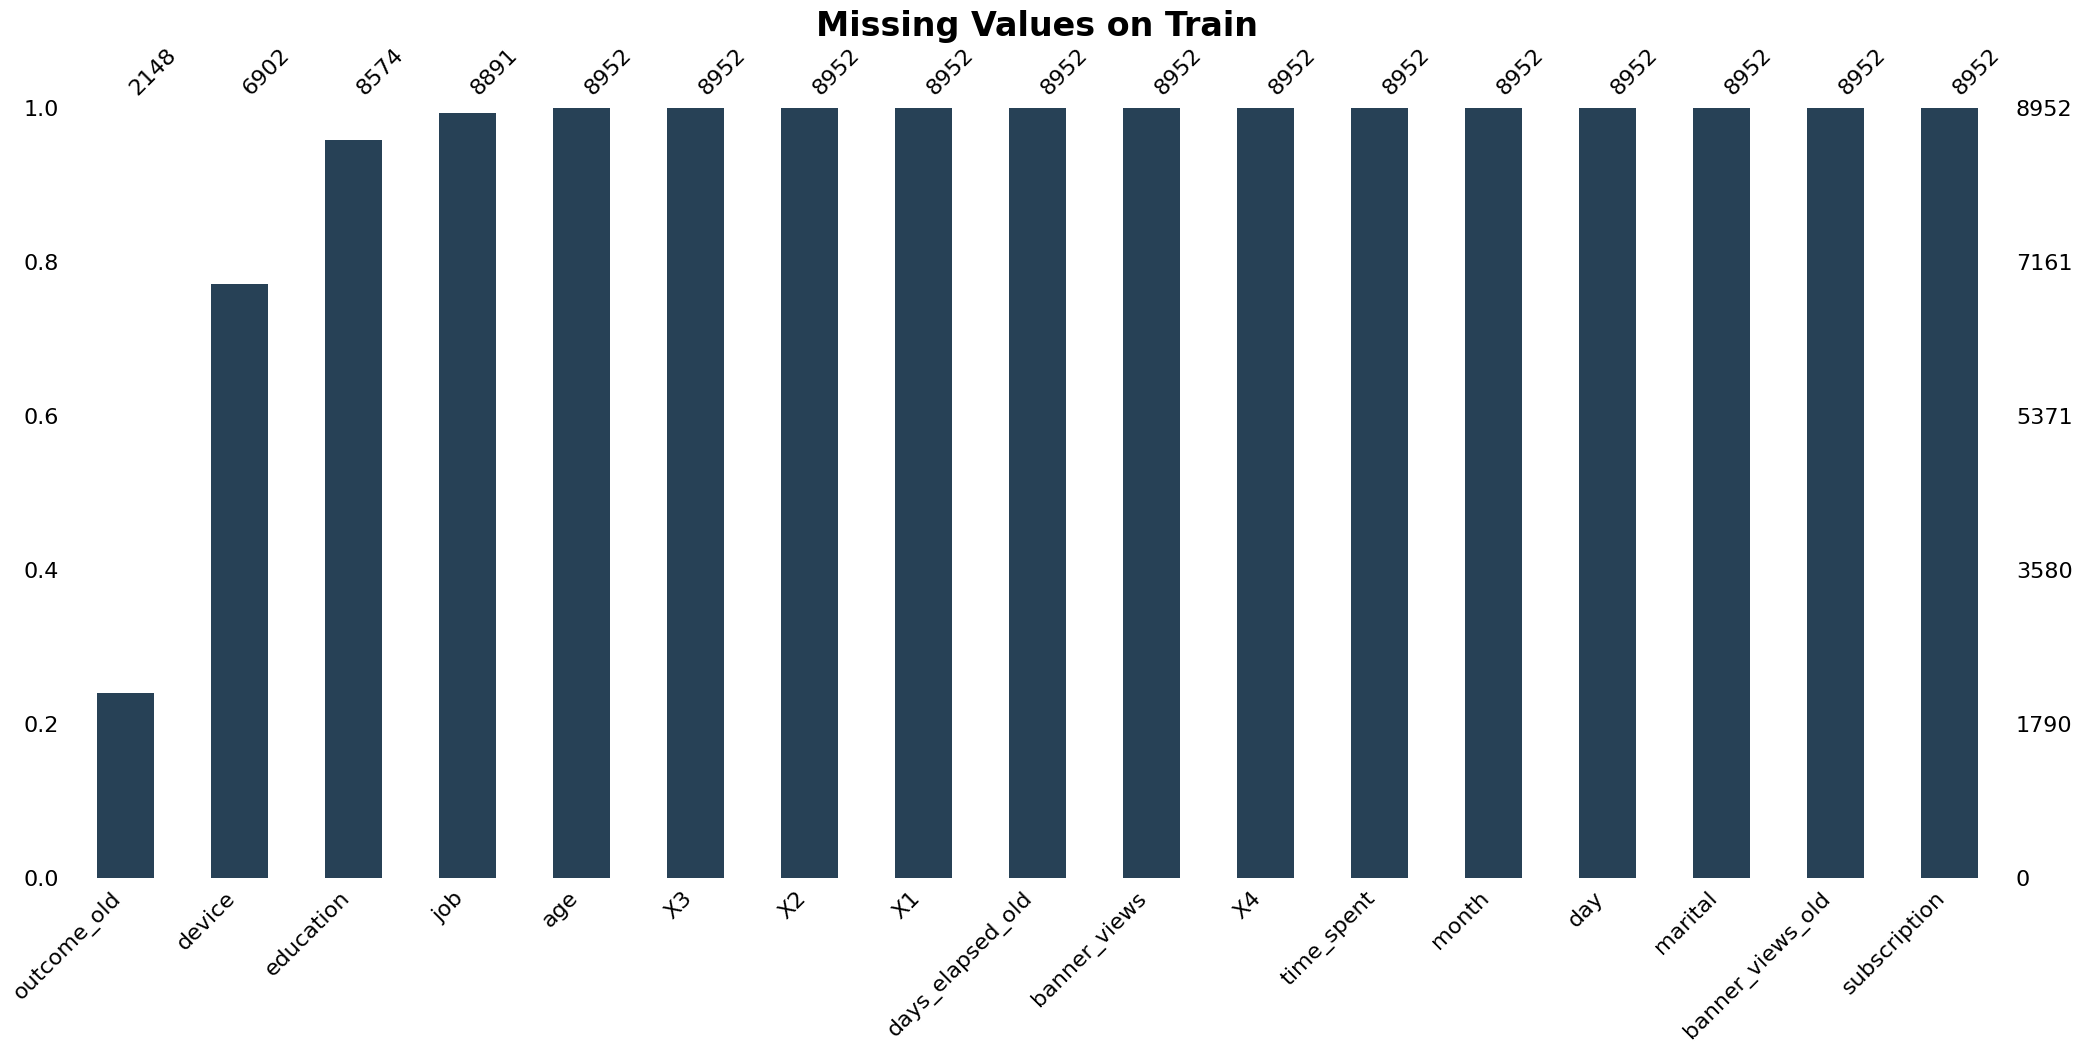

In [152]:
msno.bar(train,color=main_col, sort="ascending")
plt.title("Missing Values on Train", fontweight='bold', fontsize=24)

Text(0.5, 1.0, 'Missing Values on Test')

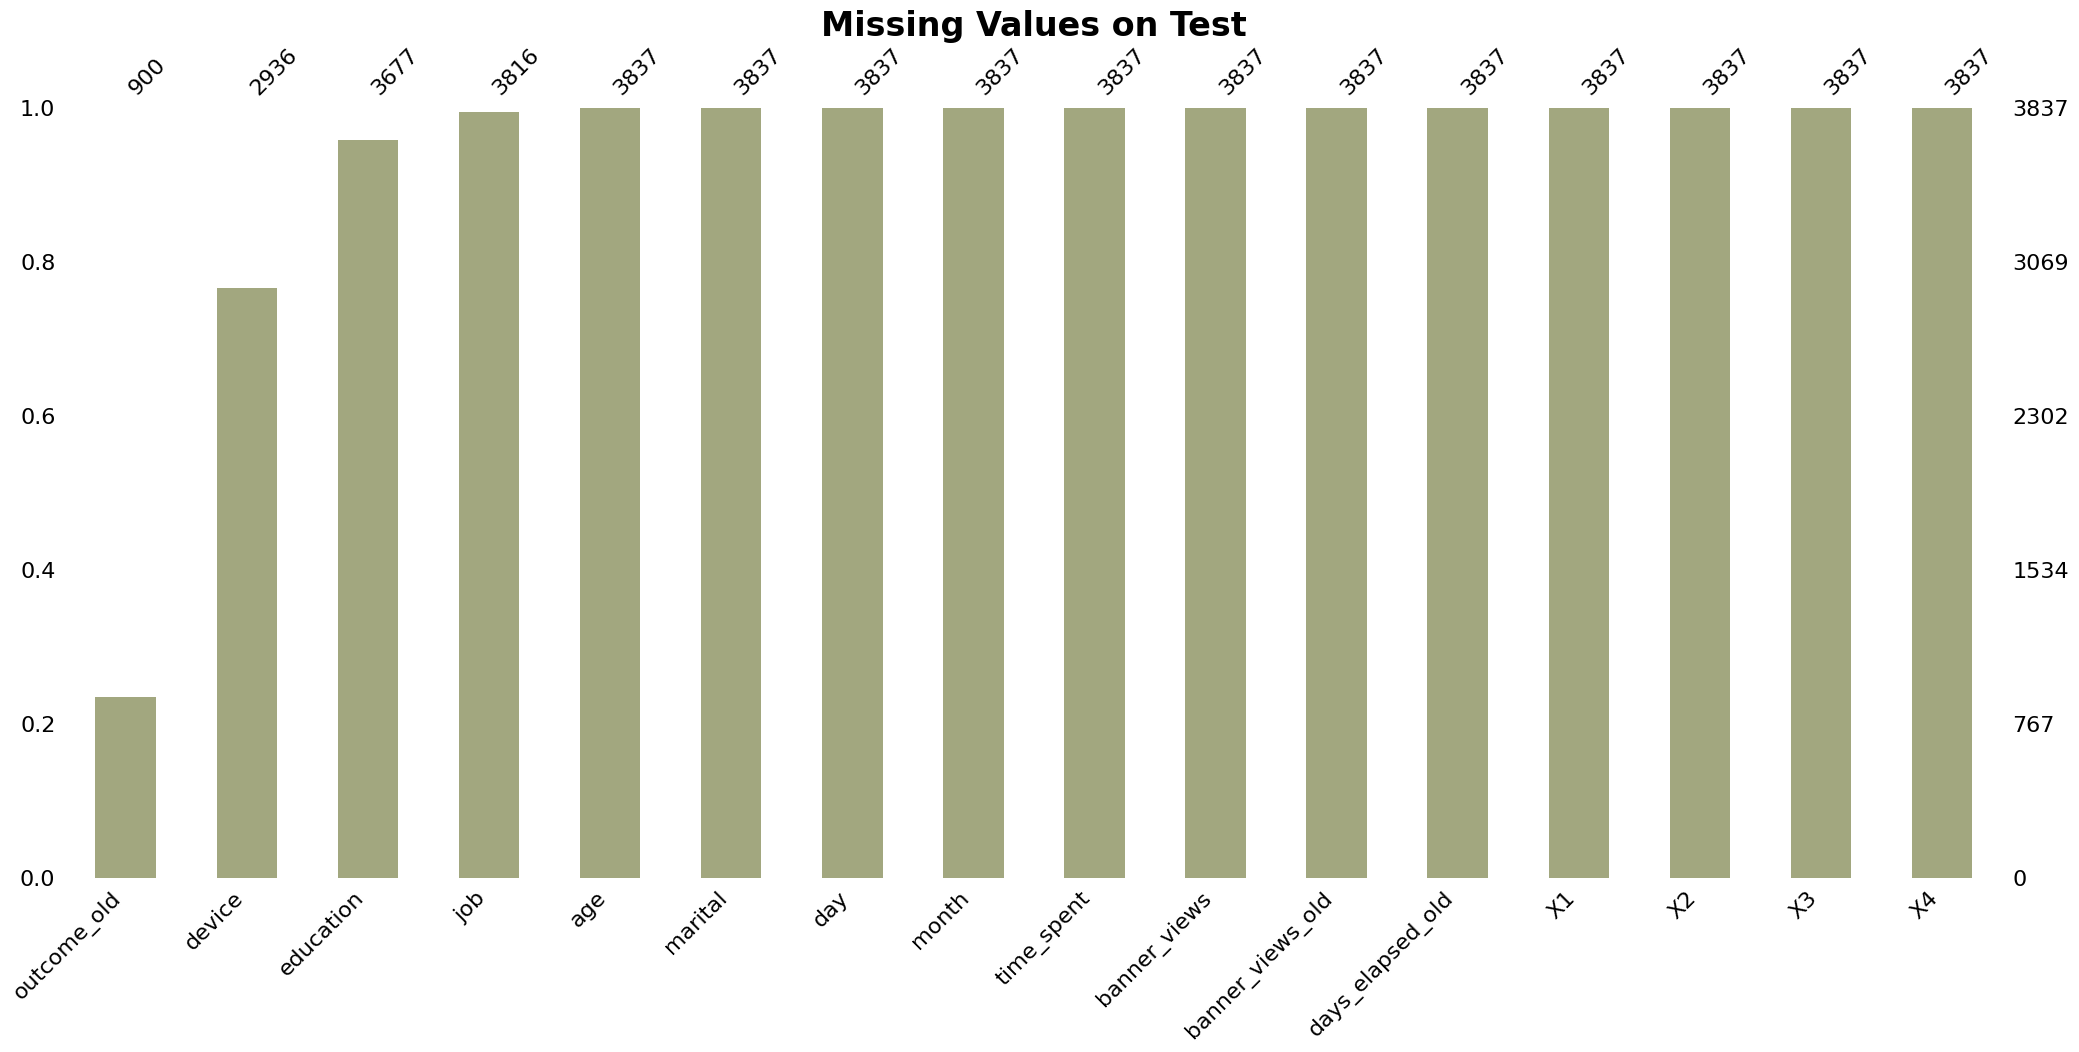

In [186]:
msno.bar(test,color=second_col, sort="ascending")
plt.title("Missing Values on Test", fontweight='bold', fontsize=24)

We better see that __outcome_old__ and __device__ are our main missings with __education__ (and __day_elapsed_old__ is -1 but still would count as a theorical missing)

## Visualization

### Train

### Numeric

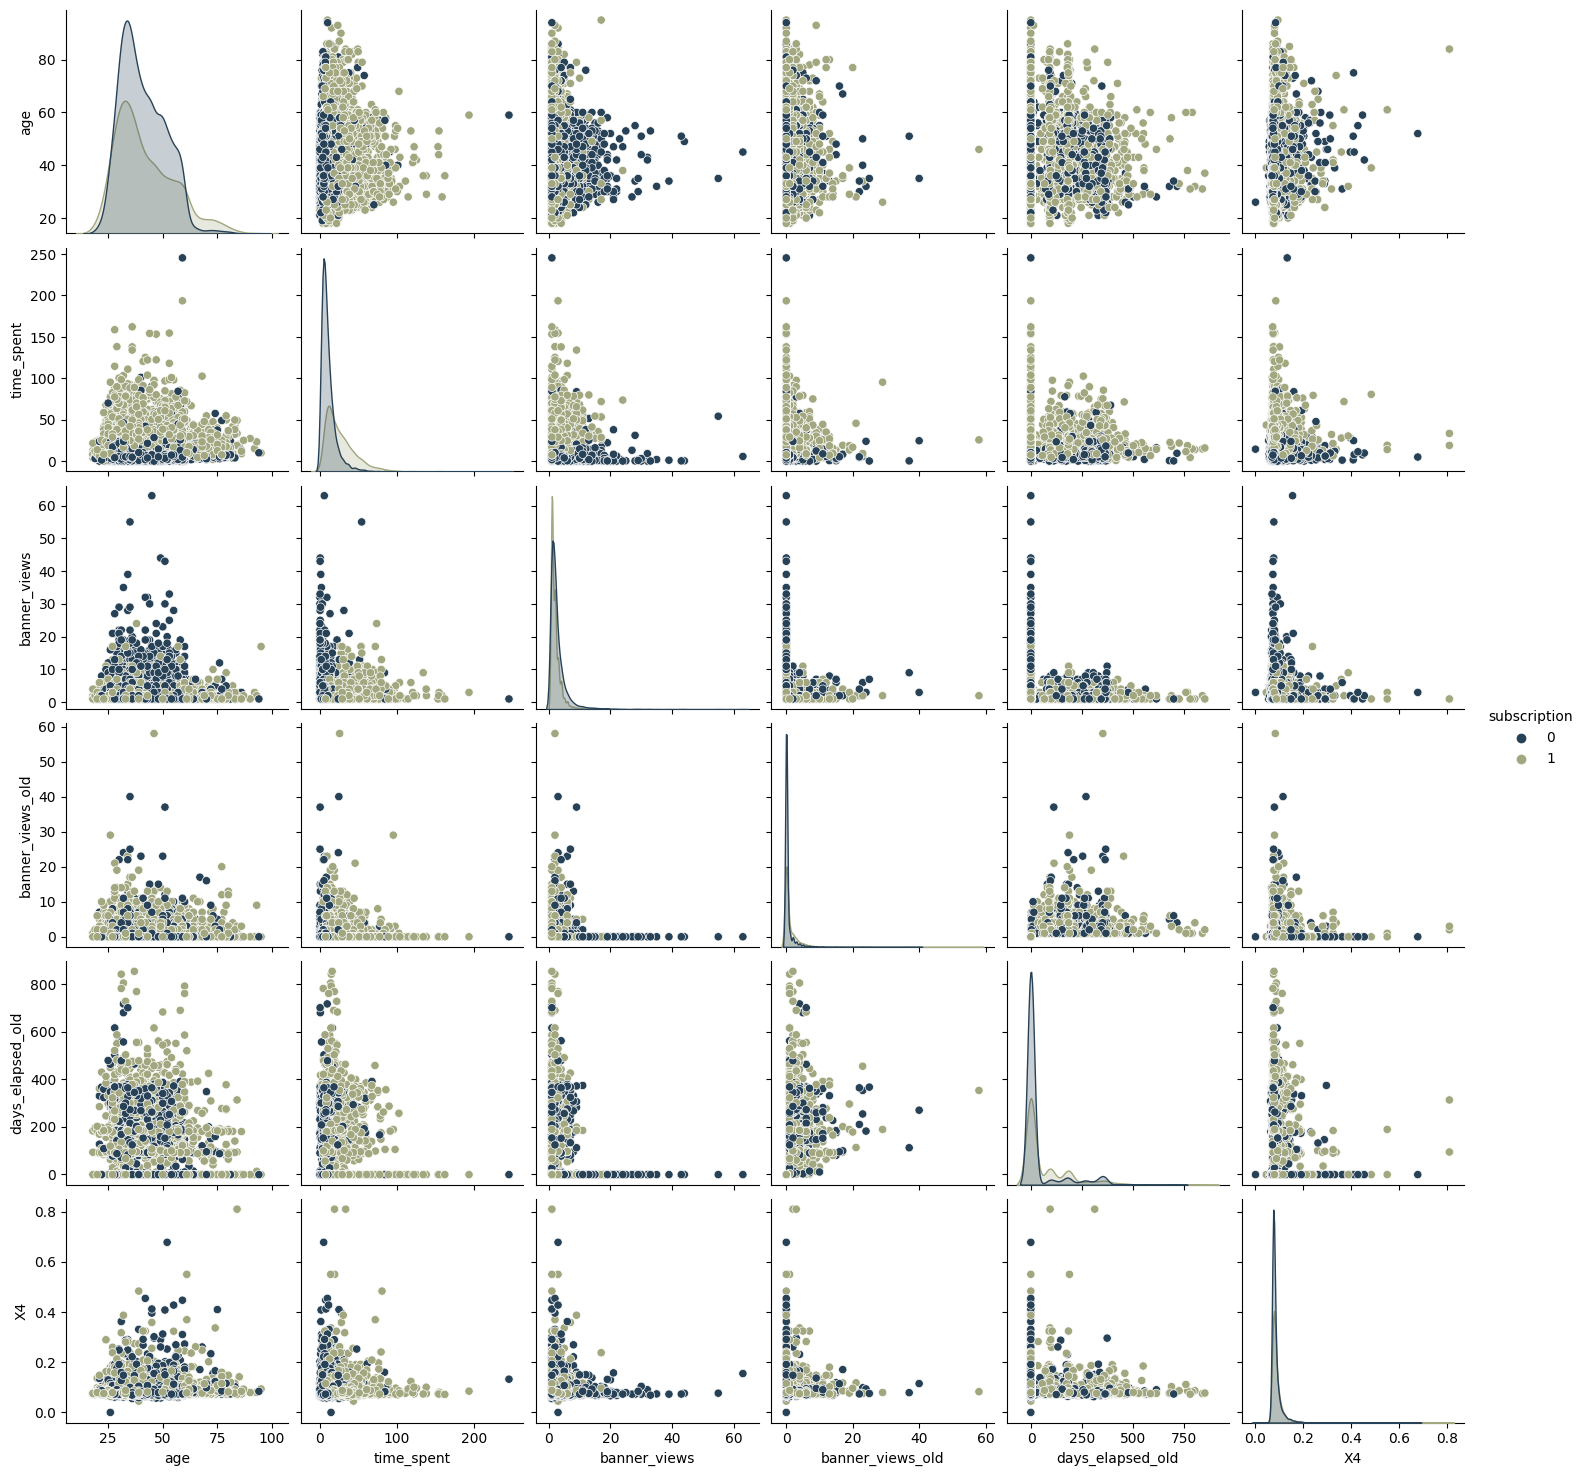

In [216]:
colors_subscription = [main_col, second_col]
sns.pairplot(train, hue = "subscription", palette=colors_subscription)

### Categorical